In [15]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# The safety of the Chicago streets

## Introduction
Crime is an escalating problem for the city of Chicago. The amount of violent crime incidents has surged by 11% and the amount of arrests has dropped compared to the previous year (Illinois Policy, 2024). This alarming trend has resulted in the highest amount of crime since the start of the new decade. Understanding the impact of crime extends beyond just recognizing its immediate effects on victims. It also affects various aspects of urban life to a certain extent. We want to know how far that certain extent goes and to make that analysis we thought of 2 perspectives.
	Perspective 1: Chicago is known for the extreme amount of crime that occurs there, which directly correlates to the amount of traffic accidents that happen there. Therefore the amount of crimes need to be reduced so that the citizens of Chicago can live peaceful lives.
	Perspective 2: The amount of Crime that occurs in Chicago is extreme but it has no direct correlation to the amount of traffic accidents that happen there. It is therefore not necessary to address the amount of crime immediately since no citizens are in harm's way.
With this project we want to shed some light on the factors at play and create a realistic picture of what is happening.





## Dataset and Preprocessing

We will analyze data from the Chicago Police Department's CLEAR database which contains the crime data. It is a dataset containing data from 2001-2017. It contains more than 6,000,000 rows of data but not all of it will be used. The reason is that we will use another dataset from the same police department that contain the records of traffic accidents from 2013-2023 and has almost 800.000 rows of data. The datasets do not span the same timeline so to make the data more relevant we will only use the overlapping years. Therefore all the data will be filtered to be only in between 2013-2017.
Furthermore, many rows are missing a collumn which means that the data needs to be filtered to what we will use. For example, some rows have the location but not the lightning condition, the data will still be used for the location visualization but not for the lightning condition visualization. This flitering will be done with every visualization so we wont miss any useful datapoints.


In [4]:
# import data
crime_data = pd.read_csv('Chicago_Crimes_2012_to_2017.csv')

crash_data = pd.read_csv('Traffic_Crashes_Crashes.csv')


In [5]:
# clean data
crash_data['CRASH_DATE'] = pd.to_datetime(crash_data['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')
crime_data['Date'] = pd.to_datetime(crime_data['Date'], format='%m/%d/%Y %I:%M:%S %p')

crime_data = crime_data[(crime_data['Date'].dt.year >= 2012) & (crime_data['Date'].dt.year <= 2017)]
crash_data = crash_data[(crash_data['CRASH_DATE'].dt.year >= 2012) & (crash_data['CRASH_DATE'].dt.year <= 2017)]



In [6]:
# Extract hour from 'CRASH_DATE'
crash_data.dropna(subset=['CRASH_DATE'], inplace=True)
crash_data['HOUR'] = crash_data['CRASH_DATE'].dt.hour

# Count the number of crashes per hour
crash_counts_per_hour = crash_data['HOUR'].value_counts().sort_index()

# Create a bar plot for crashes by hour
fig_hour = px.bar(x=crash_counts_per_hour.index, y=crash_counts_per_hour.values, labels={'x': 'Hour of the Day', 'y': 'Number of Crashes'}, title='Number of Crashes by Hour of the Day')

fig_hour.show()

In [7]:
# Assuming crime_data is already loaded and contains a 'Date' column with dates in the format "mm/dd/yyyy hh:mm:ss AM/PM"

# Convert 'Date' to datetime with explicit format
crime_data['Date'] = pd.to_datetime(crime_data['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Extract hour from 'Date'
crime_data['HOUR'] = crime_data['Date'].dt.hour

# Count the number of crimes per hour
crime_counts_per_hour = crime_data['HOUR'].value_counts().sort_index()

# Create a bar plot for crimes by hour
fig_crime_hour = px.bar(x=crime_counts_per_hour.index, y=crime_counts_per_hour.values, labels={'x': 'Hour of the Day', 'y': 'Number of Crimes'}, title='Number of Crimes by Hour of the Day')

fig_crime_hour.show()

In [8]:
# Filter crime_data for rows where 'Primary Type' is 'THEFT'
theft_data = crime_data[crime_data['Primary Type'] == 'THEFT']

# Count the number of thefts per hour
theft_counts_per_hour = theft_data['HOUR'].value_counts().sort_index()

# Assuming crash_counts_per_hour is already calculated

# Create traces for the plot
trace_crashes = go.Bar(x=crash_counts_per_hour.index, y=crash_counts_per_hour.values, name='Crashes', marker_color='blue')
trace_thefts = go.Bar(x=theft_counts_per_hour.index, y=theft_counts_per_hour.values, name='Thefts', marker_color='red')

# Create a figure and add traces
fig = go.Figure(data=[trace_crashes, trace_thefts])

# Update layout for a clear visualization
fig.update_layout(barmode='group', title='Number of Crashes and Thefts by Hour of the Day', xaxis_title='Hour of the Day', yaxis_title='Number of Incidents')

fig.show()

# Morning Period (Around 06:00)

In the early morning hours, around 06:00, both crime and vehicle crash incidents are notably low. This period typically corresponds to a time when most people are either still at home or just beginning their day. The lower activity levels on the roads and in public spaces contribute to fewer opportunities for both crimes and accidents. During this time, the reduced vehicular traffic decreases the likelihood of collisions, and the early hour, when many are still waking up, results in fewer instances of criminal activity. This pattern underscores the influence of human behavior and societal routines on the incidence of these events.

# Evening Rush Hour (Around 17:00)

Conversely, during the evening rush hour, around 17:00, there is a marked increase in both crimes and vehicle crashes. This period coincides with the time when a significant portion of the population is commuting home from work, leading to higher traffic volumes and increased road congestion. The elevated number of vehicles on the road naturally results in a higher probability of accidents.

Additionally, the heightened stress and impatience often associated with rush-hour traffic can contribute to more aggressive driving behaviors, further escalating the risk of crashes. This time frame also corresponds to when individuals are returning to their neighborhoods, creating more opportunities for interactions that can lead to criminal incidents. The convergence of a high density of people and vehicles during rush hour amplifies the potential for both vehicular and criminal incidents.

In [9]:
df_crimes = crime_data
df_crashes = crash_data

df_crimes.dropna(subset=['Latitude', 'Longitude'], inplace=True)
df_crashes.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

df_crashes = df_crashes[df_crashes['CRASH_TYPE'].str.contains('INJURY AND / OR TOW DUE TO CRASH', na=False)]
df_crimes_arrests = df_crimes[df_crimes['Arrest'] == True]

crime_count = df_crimes.shape[0]
crash_count = df_crashes.shape[0]

# Limit data to a smaller sample for performance
df_crimes = df_crimes.sample(n=2000, random_state=1)
df_crashes = df_crashes.sample(n=2000, random_state=1)

# Create a combined dataframe
df_combined = pd.DataFrame({
    'Latitude': pd.concat([df_crimes['Latitude'], df_crashes['LATITUDE']]),
    'Longitude': pd.concat([df_crimes['Longitude'], df_crashes['LONGITUDE']]),
    'Category': ['Crime'] * len(df_crimes) + ['Traffic accidents with injury'] * len(df_crashes)
})

# Define color scale
color_scale = {
    'Crime': 'blue',
    'Traffic accidents with injury': 'red'
}

# Plot the data
fig = px.scatter_mapbox(df_combined, 
                        lat="Latitude", 
                        lon="Longitude", 
                        color="Category",
                        color_discrete_map=color_scale,
                        zoom=10, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

The blue dots on the map of Chicago represent the places where a crime has occurred and the red dots are the places where a traffic accident occurred where someone got injured.

We wanted to visualize where all the crimes and traffic accidents with injuries happened since we suspect that those accidents are more often crime related. Therefore we wanted to plot the crimes on an interactive open street map if there is a correlation that is obvious for the eye.

From this visualization alone you can see that the dots on the map are most of the time clusters of dots and especially in the middle of the map you can see a horizontal line where almost no crime or traffic accidents happen. Since the dots are more clustered together, we can assume that there is some sort of correlation but what exactly is not expressively visible. 


C:\Users\tijs\AppData\Local\Temp\ipykernel_5384\569039260.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tijs\AppData\Local\Temp\ipykernel_5384\569039260.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



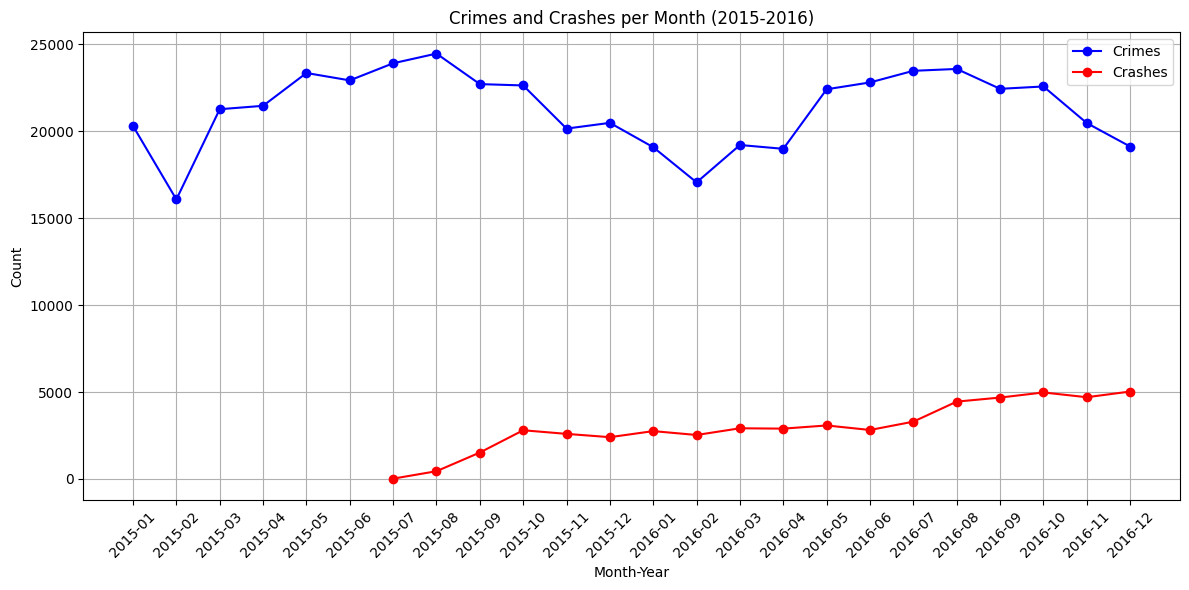

In [24]:
# Adjusting the code to filter data from 2015 to 2016 and display by month

# Ensure the 'Date' columns are in datetime format
crime_data['Date'] = pd.to_datetime(crime_data['Date'])
crash_data['CRASH_DATE'] = pd.to_datetime(crash_data['CRASH_DATE'])

# Filter crime data for years 2015 to 2016
crime_data_filtered = crime_data[(crime_data['Date'].dt.year >= 2015) & (crime_data['Date'].dt.year <= 2016)]

# Filter crash data to start from July 2015 to 2016
crash_data_filtered = crash_data[((crash_data['CRASH_DATE'].dt.year == 2015) & (crash_data['CRASH_DATE'].dt.month >= 7)) | (crash_data['CRASH_DATE'].dt.year == 2016)]

# Extract month and year for grouping
crime_data_filtered['Month_Year'] = crime_data_filtered['Date'].dt.to_period('M')
crash_data_filtered['Month_Year'] = crash_data_filtered['CRASH_DATE'].dt.to_period('M')

# Count Crimes and Crashes per Month-Year
crime_counts_filtered = crime_data_filtered.groupby('Month_Year').size().reset_index(name='Crimes')
crash_counts_filtered = crash_data_filtered.groupby('Month_Year').size().reset_index(name='Crashes')

# Plotting
plt.figure(figsize=(12, 6))

# Plot crime data
plt.plot(crime_counts_filtered['Month_Year'].astype(str), crime_counts_filtered['Crimes'], label='Crimes', marker='o', color='blue')

# Plot crash data
plt.plot(crash_counts_filtered['Month_Year'].astype(str), crash_counts_filtered['Crashes'], label='Crashes', marker='o', color='red')

plt.title('Crimes and Crashes per Month (2015-2016)')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

The data from 2015-2016 clearly indicates that there is almost no impact on the amount of vehicle crashes when considering the fluctuations in crime rates. This independence suggests that while both are critical public safety concerns, they require distinct and specialized approaches for effective management. By recognizing the unique determinants of each issue, policymakers and public safety officials can devise more precise and effective strategies to enhance overall community safety and well-being.